# Assignment #5

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.notebook import trange, tqdm

torch.__version__

'1.2.0'

In [2]:
transform = transforms.Compose([#transforms.Resize((1,10000)),
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])


#train_data_path = 'relative path of training data set'
train_data_path = '..\\Assignment#2\\horse-or-human\\train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# print(trainset)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=1)  


validation_data_path = '..\\Assignment#2\\horse-or-human\\validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False, num_workers=1)  

In [3]:
train_data = np.zeros((10000, 0))
train_label = np.zeros((0,1))
val_data = np.zeros((10000,0))
val_label = np.zeros((0,1))

# load training images of the batch size for every iteration
for i, data in enumerate(trainloader):

    # inputs is the image
    # labels is the class of the image
    inputs, labels = data
    
    # if you don't change the image size, it will be [batch_size, 1, 100, 100]
    train_data = np.hstack((train_data, np.reshape(inputs, (10000,1))))
    
    # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
    train_label = np.append(train_label, labels)

train_label = train_label.reshape(1,1027)


# load validation images of the batch size for every iteration
for i, data in enumerate(valloader):

    # inputs is the image
    # labels is the class of the image
    inputs, labels = data

    # if you don't change the image size, it will be [batch_size, 1, 100, 100]
    val_data = np.hstack((val_data, np.reshape(inputs, (10000,1))))

    # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
    val_label = np.append(val_label, labels)

val_label = val_label.reshape(1,256)


print("train_label shape : " + str(train_label.shape))
print("train_data  shape : " + str(train_data.shape))
print("val_label   shape : " + str(val_label.shape))
print("val_label   shape : " + str(val_data.shape))

train_label shape : (1, 1027)
train_data  shape : (10000, 1027)
val_label   shape : (1, 256)
val_label   shape : (10000, 256)


In [4]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

def ReLU(z):
    return np.maximum(0, z)

def LeakyReLU(z, a):
    return np.maximum(a*z, z)

# def checkConvergence():

# def getMaximum():


In [5]:
# INITIALIZE VARIABLES, EPOCH, LEARNING RATE, NUMBER OF NODES IN HIDDEN LAYER
LEARNING_RATE = 0.005
NUM_EPOCH = 25000
NUM_HIDDEN_LAYER_1 = 7
NUM_HIDDEN_LAYER_2 = 4
EPSILON = 0.00000000001

NUM_TRAIN_DATA = train_data.shape[1]
NUM_VAL_DATA = val_data.shape[1]
IMAGE_VECTOR_LEN = train_data.shape[0]

w_1 = np.random.randn(NUM_HIDDEN_LAYER_1,10000) * 0.01
w_2 = np.random.randn(NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1) * 0.01
w_3 = np.random.randn(1, NUM_HIDDEN_LAYER_2) * 0.01

b_1 = 0
b_2 = 0
b_3 = 0

train_loss = np.zeros((2,NUM_EPOCH))
train_accuracy = np.zeros((2,NUM_EPOCH))
val_loss = np.zeros((2,NUM_EPOCH))
val_accuracy = np.zeros((2,NUM_EPOCH))

In [6]:
prev_loss = 0
loss = 0

for i in trange(NUM_EPOCH, desc="EPOCH"):
    J = 0   
    dw_1 = np.zeros((NUM_HIDDEN_LAYER_1, 10000))
    dw_2 = np.zeros((NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1))
    dw_3 = np.zeros((1, NUM_HIDDEN_LAYER_2))
    
    db_1 = 0
    db_2 = 0
    db_3 = 0
    
    dz_1 = 0
    dz_2 = 0
    dz_3 = 0
    
    # COMPUTATION OF THE GRADIENT AND UPDATE OF MODEL PARAMETERS
    z_1 = np.dot(w_1, train_data) + b_1
    A_1 = tanh(z_1)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = tanh(z_2)

    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)

    # COMPUTAION OF DERIVATIVES
    dz_3 = A_3 - train_label
    dw_3 = np.dot(dz_3, A_2.T) / NUM_TRAIN_DATA
    db_3 = np.sum(dz_3, axis=1, keepdims=True) / NUM_TRAIN_DATA

    dz_2 = np.dot(w_3.T, dz_3) * (1+A_2) * (1-A_2)
    dw_2 = np.dot(dz_2, A_1.T) / NUM_TRAIN_DATA
    db_2 = np.sum(dz_2, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    dz_1 = np.dot(w_2.T, dz_2) * (1+A_1) * (1-A_1)
    dw_1 = np.dot(dz_1, train_data.T) / NUM_TRAIN_DATA
    db_1 = np.sum(dz_1, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    # UPDATE PARAMETERS
    w_1 = w_1 - LEARNING_RATE * dw_1
    w_2 = w_2 - LEARNING_RATE * dw_2
    w_3 = w_3 - LEARNING_RATE * dw_3
    
    b_1 = b_1 - LEARNING_RATE * db_1
    b_2 = b_2 - LEARNING_RATE * db_2
    b_3 = b_3 - LEARNING_RATE * db_3
    
    
    # FOR CALCULATING TRAIN LOSS
    J = (np.dot(train_label, (np.log(A_3)).T) + np.dot(1-train_label, (np.log(1-A_3)).T))
    J = -np.sum(J) / NUM_TRAIN_DATA
    train_loss[0][i] = i+1
    train_loss[1][i] = J
    loss = J
    
    # FOR CALCULATING TRAIN ACCURACY
    for x in range(NUM_TRAIN_DATA):
        if A_3[0][x] >= 0.5:
            A_3[0][x] = 1
        else:
            A_3[0][x] = 0
    
    correct = 0
    for x in range(NUM_TRAIN_DATA):
        if A_3[0][x] == train_label[0][x]:
            correct += 1
        
    train_accuracy[0][i] = i+1
    train_accuracy[1][i] = correct/NUM_TRAIN_DATA
    
    # FOR CALCULATING VALIDATION LOSS   
    z_1 = np.dot(w_1, val_data) + b_1
    A_1 = tanh(z_1)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = tanh(z_2)
    
    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)
    
    J = (np.dot(val_label, (np.log(A_3)).T) + np.dot(1-val_label, (np.log(1-A_3)).T))
    J = -np.sum(J)/NUM_VAL_DATA
    val_loss[0][i] = i+1
    val_loss[1][i] = J
    
    # FOR CALCULATING VALIDATION ACCURACY
    for x in range(NUM_VAL_DATA):
        if A_3[0][x] >= 0.5:
            A_3[0][x] = 1
        else:
            A_3[0][x] = 0
    
    correct = 0
    for x in range(NUM_VAL_DATA):
        if A_3[0][x] == val_label[0][x]:
            correct += 1
        
    val_accuracy[0][i] = i+1
    val_accuracy[1][i] = correct/NUM_VAL_DATA

#     if abs(loss - prev_loss) < EPSILON :
#         print("Train loss converged at Epoch " + str(i+1))
#         break
#     prev_loss = loss 

In [7]:
# FIND FINAL ACCURACY AND LOSS OF DATASETS
temp = val_accuracy[1][0]
index = val_accuracy[0][0]
for x in range(NUM_EPOCH):
    if temp < val_accuracy[1][x]:
        temp = val_accuracy[1][x]
        index = val_accuracy[0][x]

index = int(index)

# val_accuracy = max(sig_val_accuracy)
# index = sig_val_accuracy.index(val_accuracy)

print("Train_Loss     : " + str(train_loss[1][index-1]))
print("Train_Accuracy : " + str(train_accuracy[1][index-1]))
print("Val_Loss       : " + str(val_loss[1][index-1]))
print("Val_Accuracy   : " + str(val_accuracy[1][index-1]))

Train_Loss     : 0.2093408308758668
Train_Accuracy : 0.9328140214216164
Val_Loss       : 0.31169653554420884
Val_Accuracy   : 0.8984375


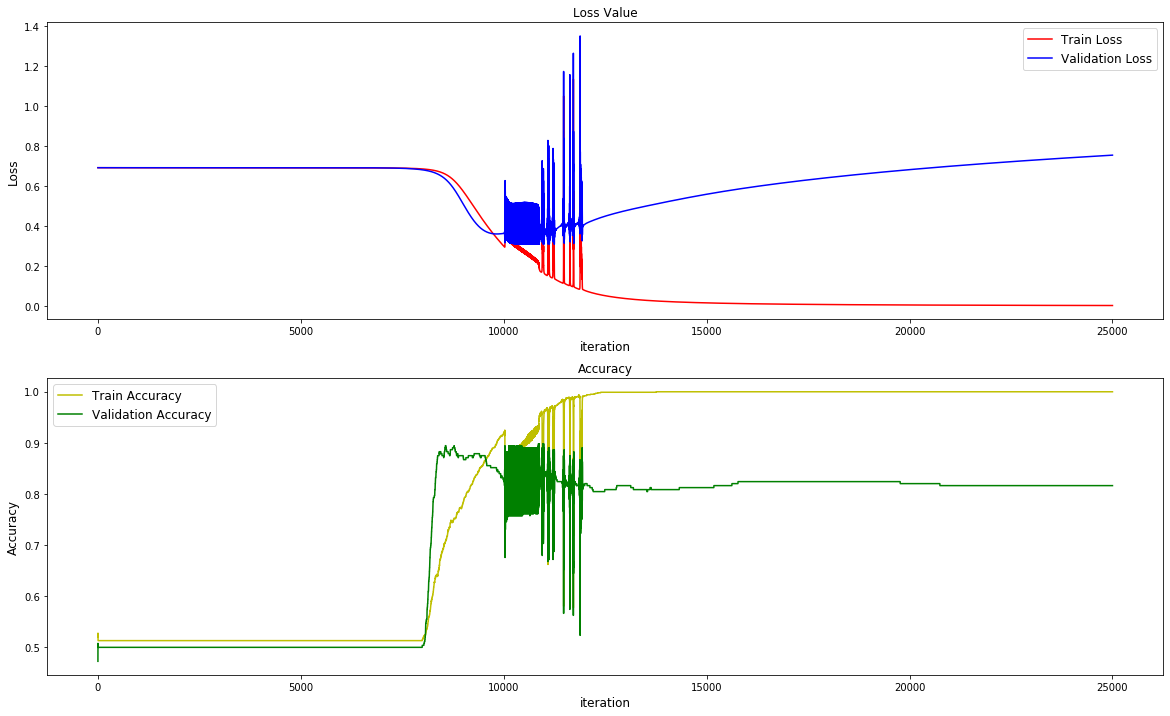

In [8]:
# PLOT TRAIN AND VALIDATION LOSS AT EVERY ITERATION
fig, ax2 = plt.subplots(2,1,figsize=(20,12))
ax2[0].set_title("Loss Value")
ax2[0].set_ylabel("Loss", fontsize="12")
ax2[0].set_xlabel("iteration", fontsize="12")
ax2[0].plot(train_loss[0], train_loss[1],'-r', label='Train Loss')
ax2[0].plot(val_loss[0], val_loss[1], '-b', label='Validation Loss')
ax2[0].legend(fontsize="12")

# PLOT TRAIN AND VALIDATION ACCURACY AT EVERY ITERATION
ax2[1].set_title("Accuracy")
ax2[1].set_ylabel("Accuracy", fontsize="12")
ax2[1].set_xlabel("iteration", fontsize="12")
ax2[1].plot(train_accuracy[0], train_accuracy[1], '-y', label='Train Accuracy')
ax2[1].plot(val_accuracy[0], val_accuracy[1], '-g', label='Validation Accuracy')
ax2[1].legend(fontsize="12")
plt.show()

### Result

| Dataset | Loss | Accuracy |
|:--|--|--|
|Train (at Convergence)| {{train_loss[1][NUM_EPOCH-1]}} | {{train_accuracy[1][NUM_EPOCH-1]}} |
|Validation (at Convergence)| {{val_loss[1][NUM_EPOCH-1]}} | {{val_accuracy[1][NUM_EPOCH-1]}} |
|Validation (at Best)| {{val_loss[1][index-1]}} | {{val_accuracy[1][index-1]}} |